# Thermal contrast (Barerock)

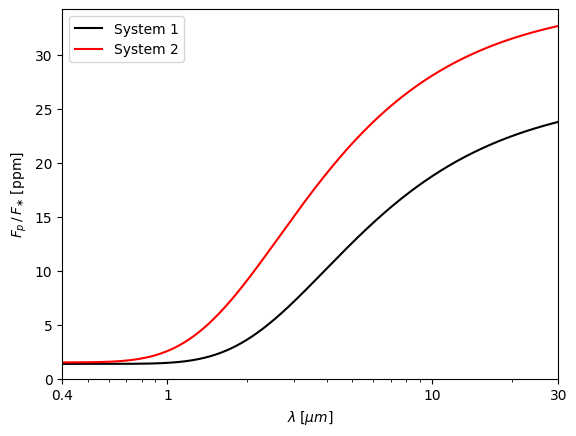

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

AU = 1.495978707e11
R_earth = 6.378e6
h = 6.62607015e-34
c = 299792458
k = 1.380649e-23
T_star = 5000
R_star = 6.96342e8

tau = 0 # due to the barerock scenario of no atmosphere (P = 0, mu*m_H becomes irrelevant)

# dictionary with tuples as entries: [0] is for system 1, [1] for system 2:
val = {"T_surf": [1500, 2000], "A_g": [0.3, 0.3], "a": [0.01992*AU, 0.019*AU], "R_p": [R_earth, R_earth]}

def planck(Lambda, T):
    return ((2*h*c**2)/(Lambda**5))*(1/(np.exp((h*c)/(Lambda*k*T))-1))

def contrast(i, Lambda):
    return (val["R_p"][i]/R_star)**2*(planck(Lambda, val["T_surf"][i])/planck(Lambda, T_star)) + (val["R_p"][i]/val["a"][i])**2*val["A_g"][i]

# custom x- and y-axis ticks:
def custom_tick_formatter(value, pos):
    return f"{value:g}"  # Dezimaldarstellung für andere Werte

# axis presave as multiple plots will be created:
def axis_presave(axis):
    axis.set_xscale("log", base=10)
    axis.set_xlabel(r"$\lambda \; [\mu m]$")
    axis.set_ylabel(r"${F_p}\,/\,{F_{\ast}} \; [\text{ppm}]$")
    axis.set_xlim(0.4, 30)
    axis.set_ylim(0, None)
    axis.set_xticks([0.4, 1, 10, 30])
    formatter = ticker.FuncFormatter(custom_tick_formatter)
    axis.xaxis.set_major_formatter(formatter)

# x and y values:
wavelengths = np.arange(0.1, 30, 0.01)
contrast_sys1 = [1e6*contrast(0, Lambda*1e-6) for Lambda in wavelengths]
contrast_sys2 = [1e6*contrast(1, Lambda*1e-6) for Lambda in wavelengths]

# plot:
fig, axs = plt.subplots()
axs.plot(wavelengths, contrast_sys1, label="System 1", color="black")
axs.plot(wavelengths, contrast_sys2, label="System 2", color="red")

axis_presave(axs)

axs.legend()
plt.savefig("images/emission_task1.pdf", bbox_inches="tight")
plt.show()

# Barerock scenario 1 for different albedos

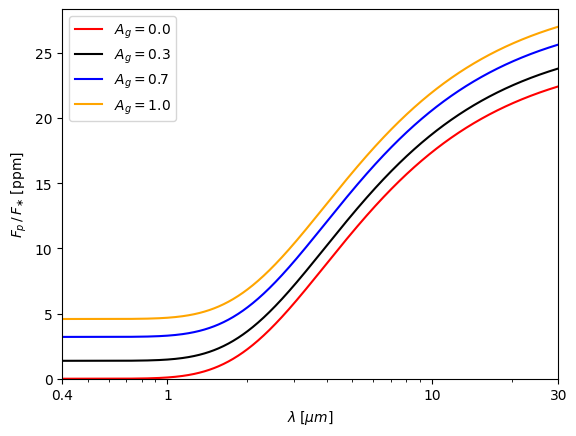

In [8]:
A_g = [(0.0, "red"), (0.3, "black"), (0.7, "blue"), (1.0, "orange")]

fig, axs = plt.subplots()
for value in A_g:
    val["A_g"][0] = value[0]
    contrast_sys1 = [1e6*contrast(0, Lambda*1e-6) for Lambda in wavelengths]
    axs.plot(wavelengths, contrast_sys1, label=fr"$A_g = {value[0]}$", color=value[1])
val["A_g"][0] = 0.3 # set to original value

axis_presave(axs)

axs.legend()
plt.savefig("images/emission_task2.pdf", bbox_inches="tight")
plt.show()

# Thermal emission spectra with atmospheres

44.009 28.009999999999998 16.043


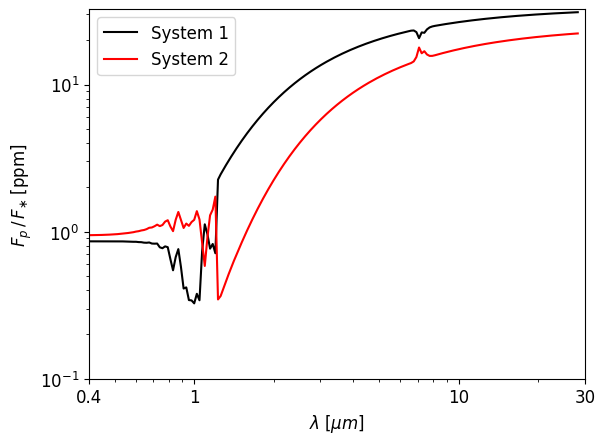

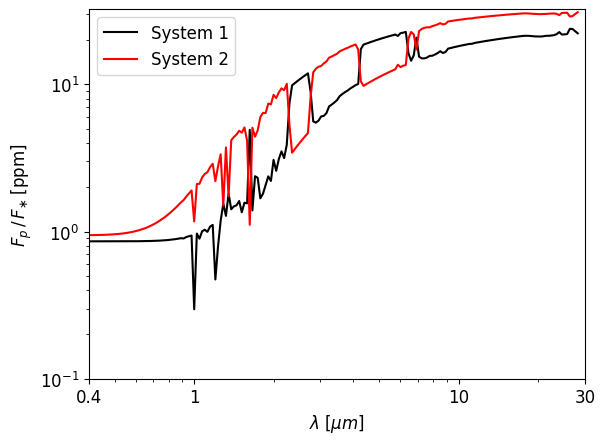

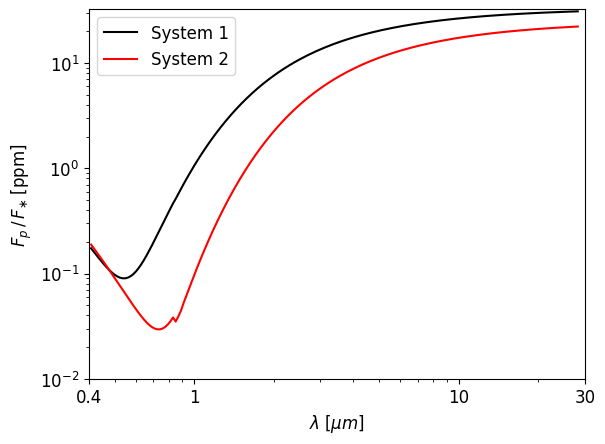

In [19]:
val["T_atmos"] = [2000, 1500]
val["P"] = [1e5, 1e5]
val["g"] = [9.8, 9.8]

m_H = 1.673e-27 # atomic mass of hydrogen
mu_CO2 = 1*12.011 + 2*15.999
mu_CO = 1*12.011 + 1*15.999
mu_CH4 = 1*12.011 + 4*1.008
print(mu_CO2, mu_CO, mu_CH4)

atmospheres = [("CO2", mu_CO2), ("CO", mu_CO), ("CH4", mu_CH4)]

data_CO2 = np.loadtxt("exoplanetary_atmospheres_data_new/cross_sections_CO2.dat")
cross_section_wl = data_CO2[:,0]*1e-2
data_CO = np.loadtxt("exoplanetary_atmospheres_data_new/cross_sections_CO.dat")
data_CH4 = np.loadtxt("exoplanetary_atmospheres_data_new/cross_sections_CH4.dat")

def get_sigma(Lambda_index, atmosphere):
    if atmosphere[0] == "CO2":
        return data_CO2[:,1][Lambda_index]*1e-4
    elif atmosphere[0] == "CO":
        return data_CO[:,1][Lambda_index]*1e-4
    else:
        return data_CH4[:,1][Lambda_index]*1e-4

def tau(Lambda_index, atmosphere, P, g):
    return ((P*get_sigma(Lambda_index, atmosphere))/(g*atmosphere[1]*m_H))

def get_albedo(Lambda_index, atmosphere):
    if atmosphere[0] == "CO2":
        omega = data_CO2[:,3][Lambda_index]
    elif atmosphere[0] == "CO":
        omega = data_CO[:,3][Lambda_index]
    else:
        omega = data_CH4[:,3][Lambda_index]
    return (3*omega)/16

def contrast_atmos(i, Lambda, atmosphere, Lambda_index):
    return ((val["R_p"][i]/R_star)**2*(planck(Lambda, val["T_surf"][i]) * np.exp(- tau(Lambda_index, atmosphere, val["P"][i], val["g"][i]))
                                       + (1-np.exp(- tau(Lambda_index, atmosphere, val["P"][i], val["g"][i])))
                                       * planck(Lambda, val["T_atmos"][i]))/planck(Lambda, T_star)
                                       + (val["R_p"][i]/val["a"][i])**2*get_albedo(Lambda_index, atmosphere))

# Plot:
font = {'size'   : 12}
plt.rc('font', **font)

for value in atmospheres:
    # create data:
    contrast_sys1_atmos = [1e6*contrast_atmos(0, Lambda, value, Lambda_index) for Lambda_index, Lambda in enumerate(cross_section_wl)]
    contrast_sys2_atmos = [1e6*contrast_atmos(1, Lambda, value, Lambda_index) for Lambda_index, Lambda in enumerate(cross_section_wl)]
    # Lambda_index is necessary to find the corresponding entry for the crosssection

    fig, axs = plt.subplots()
    axs.plot(cross_section_wl*1e6, contrast_sys1_atmos, label="System 1", color="black")
    axs.plot(cross_section_wl*1e6, contrast_sys2_atmos, label="System 2", color="red")

    axis_presave(axs)
    axs.set_yscale("log", base=10)
    # change of y-axis scaling in CH4-plot:
    if value[0] == "CH4":
        axs.set_ylim(1e-2, None)
    else:
        axs.set_ylim(1e-1, None)

    axs.legend()

    plt.savefig(f"images/emission_task3_{value[0]}.pdf", bbox_inches="tight")
    plt.show()